# Computing the Maximum Lyapunov Exponent via displacement

We compare the MLE for standard training and robust training

In [35]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 57
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

57



# Data preparation

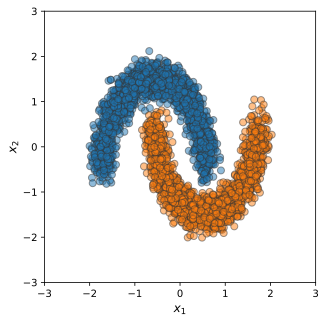

In [44]:
cross_entropy = False #this leads to squared loss in the training
data_noise = 0.1
batch_size = 5000
plotlim = [-3, 3]
subfolder = 'traj_moons'


if cross_entropy == True:
    label = 'scalar'
else: label = 'vector'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, batch_size = batch_size, plotlim = plotlim, random_state = seed, label = label)


## Model dynamics

In [45]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 1, 10
bound = 0.
fp = False #this recent change made things not work anymore
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'outside' #outside


## Training and generating level sets

In [46]:

num_epochs = 100 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


In [47]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/63
Loss: 1.776

Iteration 10/63
Loss: 2.222

Iteration 20/63
Loss: 2.046

Iteration 30/63
Loss: 1.874

Iteration 40/63
Loss: 1.774

Iteration 50/63
Loss: 1.800

Iteration 60/63
Loss: 1.723
Epoch 1: 1.871

Iteration 0/63
Loss: 1.911

Iteration 10/63
Loss: 1.543

Iteration 20/63
Loss: 1.683

Iteration 30/63
Loss: 1.606

Iteration 40/63
Loss: 1.436

Iteration 50/63
Loss: 1.354

Iteration 60/63
Loss: 1.408
Epoch 2: 1.576

Iteration 0/63
Loss: 1.716

Iteration 10/63
Loss: 1.614

Iteration 20/63
Loss: 1.494

Iteration 30/63
Loss: 1.289

Iteration 40/63
Loss: 1.500

Iteration 50/63
Loss: 1.376

Iteration 60/63
Loss: 1.402
Epoch 3: 1.348

Iteration 0/63
Loss: 1.114

Iteration 10/63
Loss: 1.192

Iteration 20/63
Loss: 1.133

Iteration 30/63
Loss: 1.148

Iteration 40/63
Loss: 1.311

Iteration 50/63
Loss: 1.073

Iteration 60/63
Loss: 0.880
Epoch 4: 1.178

Iteration 0/63
Loss: 1.350

Iteration 10/63
Loss: 1.034

Iteration 20/63
Loss: 0.910

Iteration 30/63
Loss: 0.957

Iteration 40/63


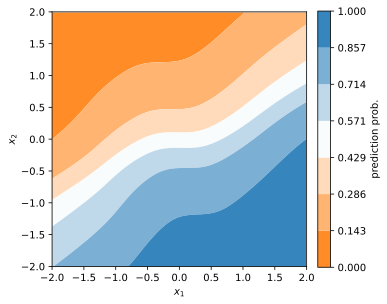

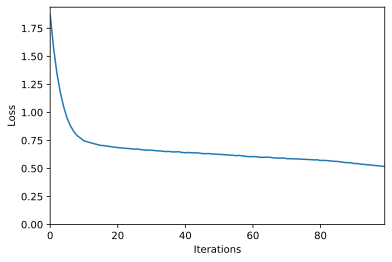

In [48]:
from plots.plots import classification_levelsets
classification_levelsets(anode)
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [49]:
# Define inputs
input1 = torch.tensor([1, 0], dtype=torch.float32)
input2 = torch.tensor([0, 1], dtype=torch.float32)
time_interval = torch.tensor([0, T], dtype=torch.float32)

def input_to_output(input):
    return anode.flow(input, time_interval)[-1]

def max_singular_value(input):
    # Compute the Jacobian matrix
    J = torch.autograd.functional.jacobian(input_to_output, input)
    
    # Perform Singular Value Decomposition
    U, S, V = torch.svd(J)
    
    # Return the maximum singular value
    return torch.max(S)

max_singular_value(input1)

tensor(2.0743)

In [50]:
x_amount = 100


x = torch.linspace(-2,2,x_amount)
y = torch.linspace(-2,2,x_amount)
X, Y = torch.meshgrid(x, y)

inputs = torch.stack([X,Y], dim=-1)
inputs = inputs.view(-1,2) #to be able to loop through all the grid values
inputs_MLE = torch.zeros(x_amount * x_amount)



for i, input in enumerate(inputs):
        
        inputs_MLE[i] = 1/T * np.log(max_singular_value(input))
    
    
output = inputs_MLE.view(x_amount,x_amount)




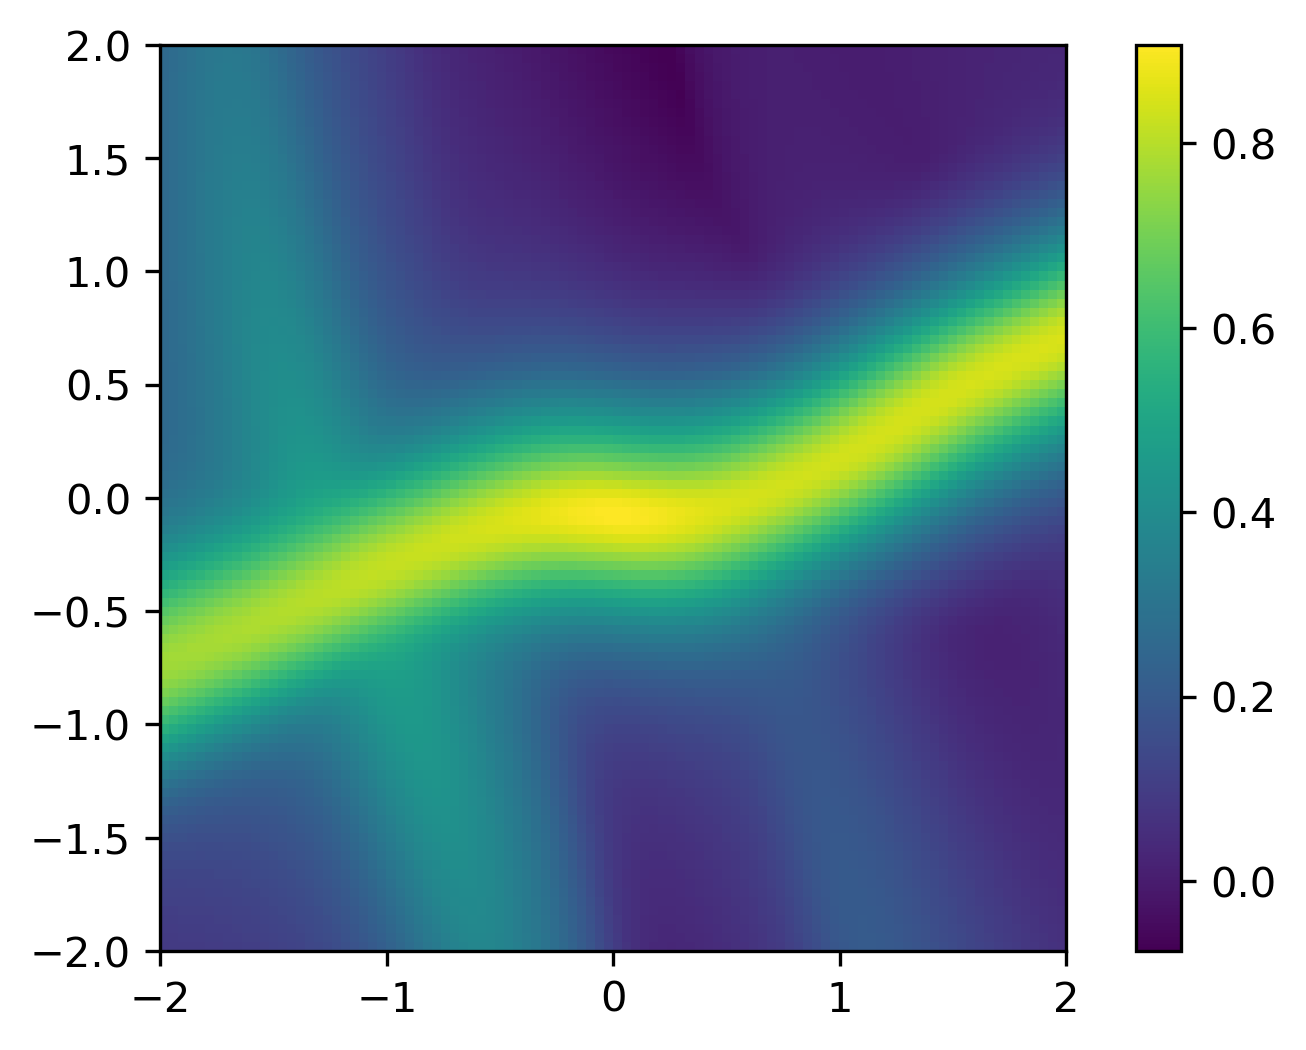

In [51]:
from matplotlib.colors import CenteredNorm, to_rgba, LinearSegmentedColormap
from IPython.display import Image

viridis = plt.get_cmap('viridis', 256)
colors = viridis(np.linspace(0, 1, 256))
colors[-1] = to_rgba('red')  # Change the last color to red
indices = [0,-1]
colors_new = colors[indices]
custom_cmap = LinearSegmentedColormap.from_list("custom_viridis", colors_new)

# colors = [to_rgb("darkblue"), to_rgb('grey'), to_rgb('red')] # first color is orange, last is blue
# custom_cmap = LinearSegmentedColormap.from_list(
#     "Custom", colors, N=40)




anodeimg = plt.imshow(np.rot90(output), origin='upper', extent=(-2, 2, -2, 2),cmap = 'viridis')#, norm=CenteredNorm(vcenter=0)) # cmap='viridis')
vmin, vmax = anodeimg.get_clim()
plt.colorbar()  # Show color scale
plt.savefig('MLE.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

# img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = 'MLE.png', width = 400)

display(img2)